If on google collab, if not skip the following cell



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/TFG_Matematicas'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/TFG_Matematicas


## EDA

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
import random
from utils.utils import *

## Loading the data

In [23]:
data_indexes = [(i+1,j+1) for i in range(10) for j in range(2000)]

In [24]:
identify_nan = False #Set to true to generate a file of discarded indexes containing unstable solutions and move those files to a discarded folder
idx_discard = set()

if identify_nan:
    #Identify data with NaN and big values to discard them
    for idx in data_indexes:
        print(idx)
        if idx not in [(6,1995)]:
            mat = np.loadtxt(f'./datos_tfg/datos_tfg/tfg_datos_{idx[0]}_{idx[1]}.txt')
            if np.isnan(mat[-1]).any() or (mat[-1] > 2).any():
                idx_discard.add(idx)

    #Save de indexes
    with open('utils/idx_nan.txt', 'w') as f:
        for idx in idx_discard:
            f.write(f"{idx[0]}, {idx[1]}\n")


with open('./utils/idx_nan.txt', 'r') as f:
    for line in f:
        idx = line.strip().split(',')
        idx_discard.add((int(idx[0]), int(idx[1].strip())))

if identify_nan:
    for idx in idx_discard:
        old_path = f"./datos_tfg/datos_tfg/tfg_datos_{idx[0]}_{idx[1]}.txt"
        new_path = f"./discarded/tfg_datos_{idx[0]}_{idx[1]}.txt"
        os.rename(old_path, new_path)
        print(f"success with {idx[0]}_{idx[1]}")

In [25]:
parameters = load_parameter_list()

In [26]:
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes
df_parameters = df_parameters[~df_parameters['data_index'].isin(idx_discard)]
df_parameters.reset_index(inplace = True, drop = True)

## Parameters analysis

In [27]:
print(f'There are {len(df_parameters)} combination of parameters.')

There are 14094 combination of parameters.


In [28]:
df_parameters.drop(['data_index'], axis=1).describe().transpose().drop(['25%','75%'], axis=1)

,count,mean,std,min,50%,max
cx,14094.0,0.491080,1.000313,-3.102034,0.483986,4.378377
cy,14094.0,3.516748,0.979522,0.276241,3.495345,7.286987
a,14094.0,1.336852,0.557621,0.015081,1.306456,4.032865
b,14094.0,0.545655,0.385499,0.000054,0.480621,2.429068
theta,14094.0,0.199972,0.318178,-1.009230,0.198383,1.435599
e1,14094.0,2.609604,1.587807,0.000006,2.460476,11.031250
e2,14094.0,4.069547,2.244209,0.000887,4.056431,13.713040


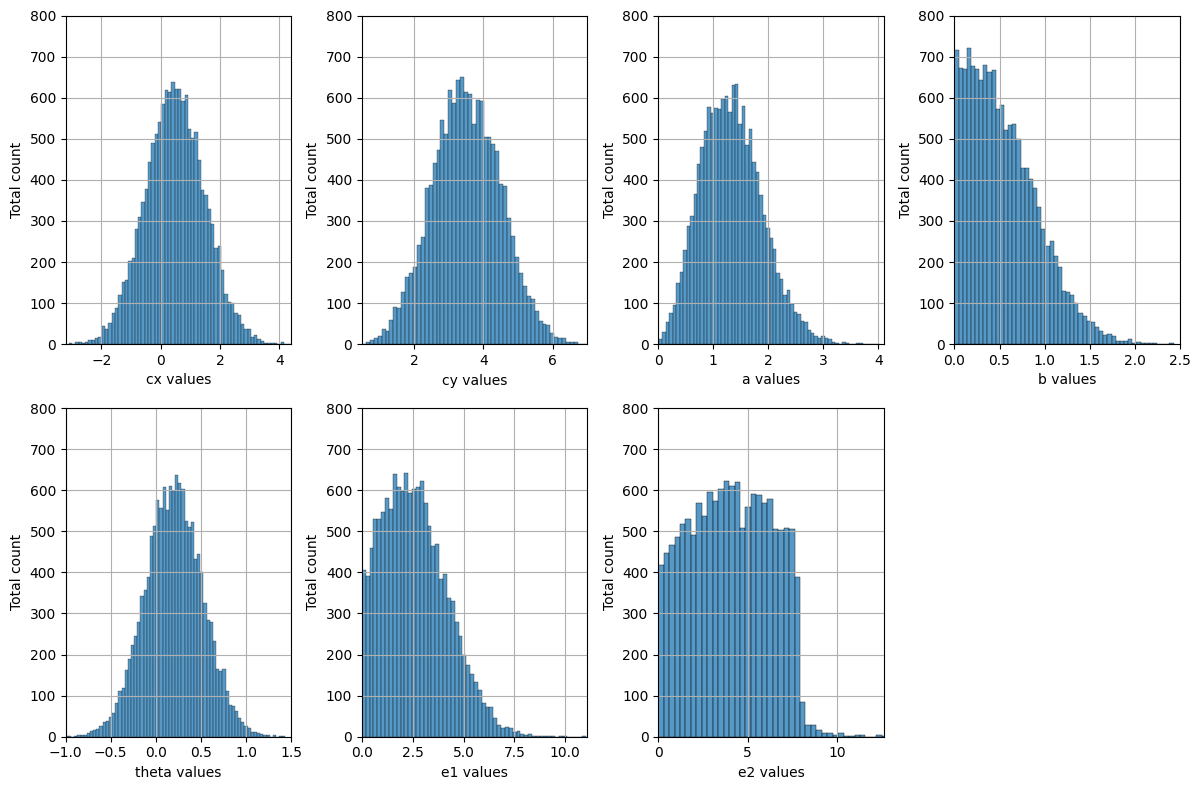

In [29]:
visualize_parameter_distributions(df_parameters, 800, file = f"./figures/parameter_distribution.jpg")

## Visualizing training data

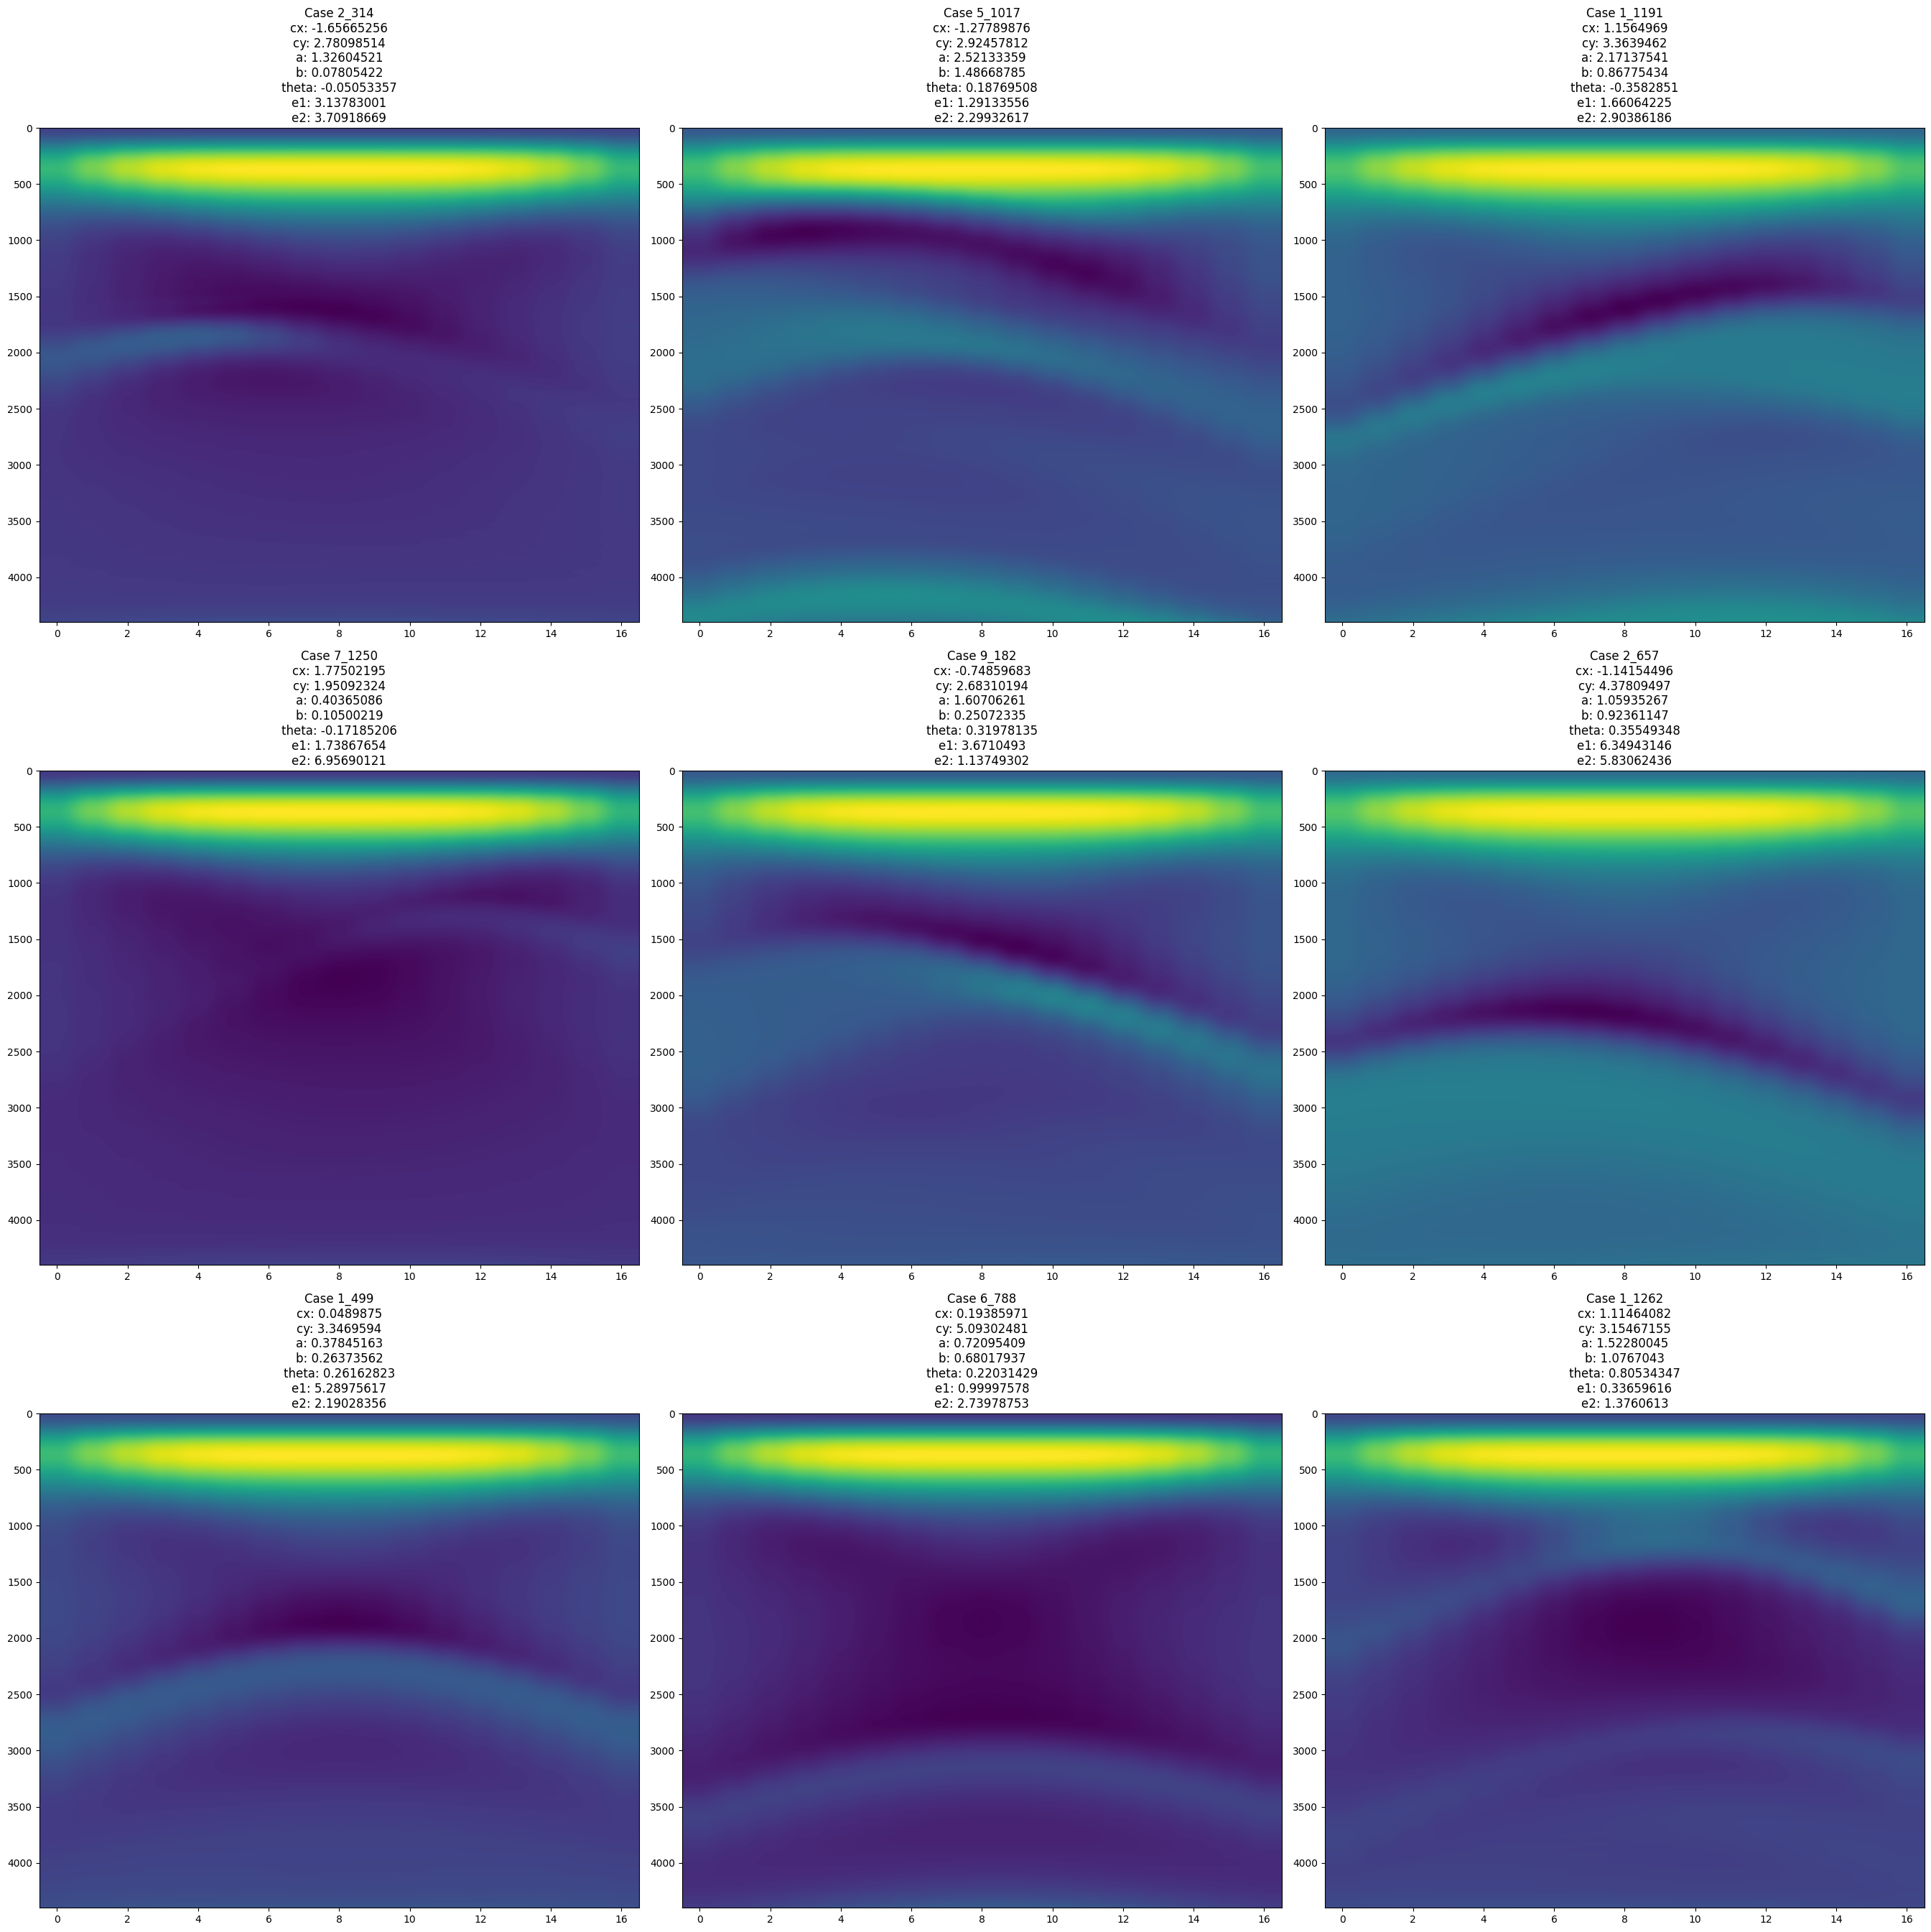

In [30]:
n = 9
idx_viz = []
for i in range(n):
    idx_1 = random.randint(1,10)
    idx_2 = random.randint(1,2000)
    while (idx_1, idx_2) in idx_discard:
        idx_1 = random.randint(1,5)
        idx_2 = random.randint(1,2000)
    idx_viz.append((idx_1,idx_2))

visualize(idx_viz, df_parameters, cols = 3, file = f"./figures/sample_9.png")

## Preprocessing

In [31]:
pip install iterative-stratification


In [32]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [33]:
X = pd.DataFrame(df_parameters['data_index'])
y = df_parameters.drop(['data_index'], axis=1)

In [34]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle = True, random_state=0)
X.loc[:, 'fold'] = -1
y.loc[:, 'fold'] = -1

In [35]:
for fold_ , (train_, valid_) in enumerate(mskf.split(X=X, y=y)):
    X.loc[valid_, 'fold'] = fold_
    y.loc[valid_, 'fold'] = fold_

------------- FOLD 0 -------------
        count      mean       std       min       50%        max
cx     2819.0  0.482191  0.998511 -2.694752  0.479107   4.138670
cy     2819.0  3.529782  0.973300  0.752617  3.520228   6.591540
a      2819.0  1.329970  0.557666  0.069034  1.297017   3.851698
b      2819.0  0.545099  0.391394  0.000378  0.481143   2.154628
theta  2819.0  0.198909  0.317009 -0.838067  0.197071   1.319627
e1     2819.0  2.635886  1.598463  0.000006  2.530391  10.031247
e2     2819.0  4.007124  2.242756  0.001369  3.969784  13.292454
fold   2819.0  0.000000  0.000000  0.000000  0.000000   0.000000


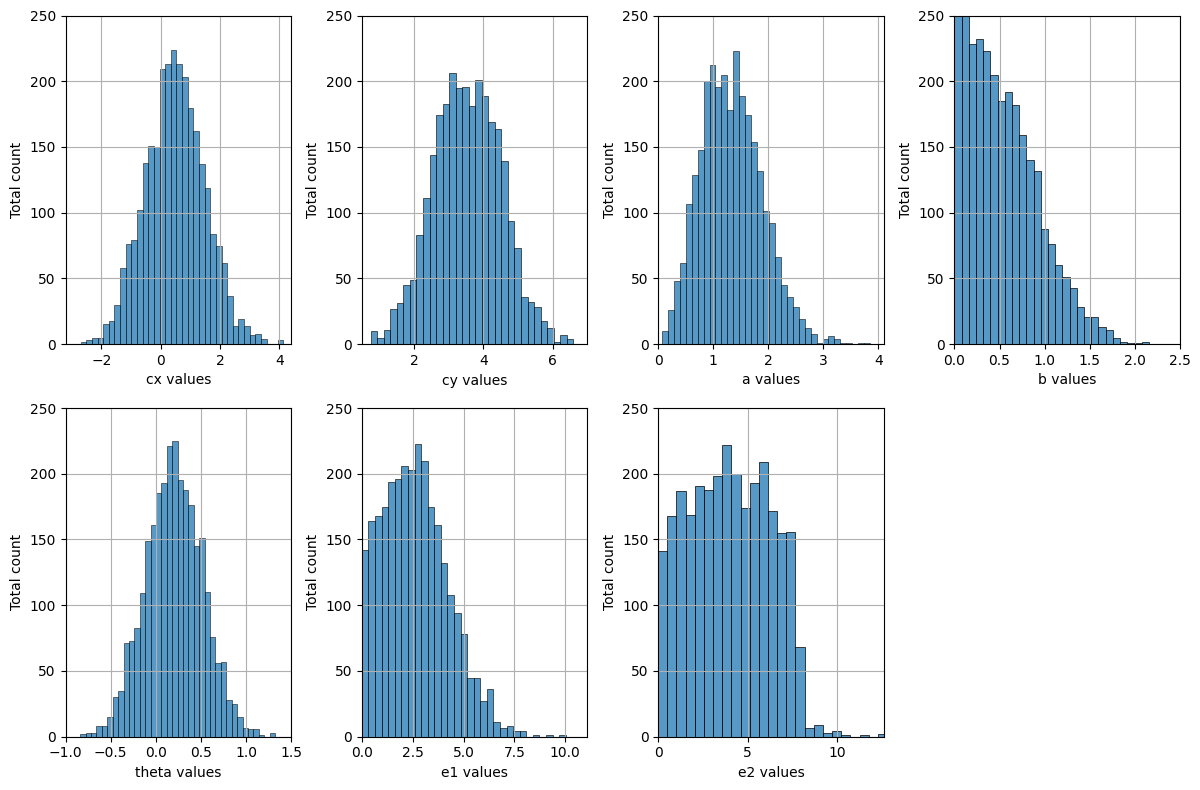

------------- FOLD 1 -------------
        count      mean       std       min       50%        max
cx     2818.0  0.499843  1.006421 -2.835535  0.472494   3.869413
cy     2818.0  3.519302  0.980968  0.276241  3.498841   6.712479
a      2818.0  1.327941  0.558258  0.015081  1.294292   3.545512
b      2818.0  0.532908  0.378656  0.000287  0.459373   2.073135
theta  2818.0  0.206611  0.321937 -0.886144  0.212490   1.312256
e1     2818.0  2.600165  1.569706  0.001776  2.432634   8.475540
e2     2818.0  4.088581  2.232995  0.001481  4.123464  11.214868
fold   2818.0  1.000000  0.000000  1.000000  1.000000   1.000000


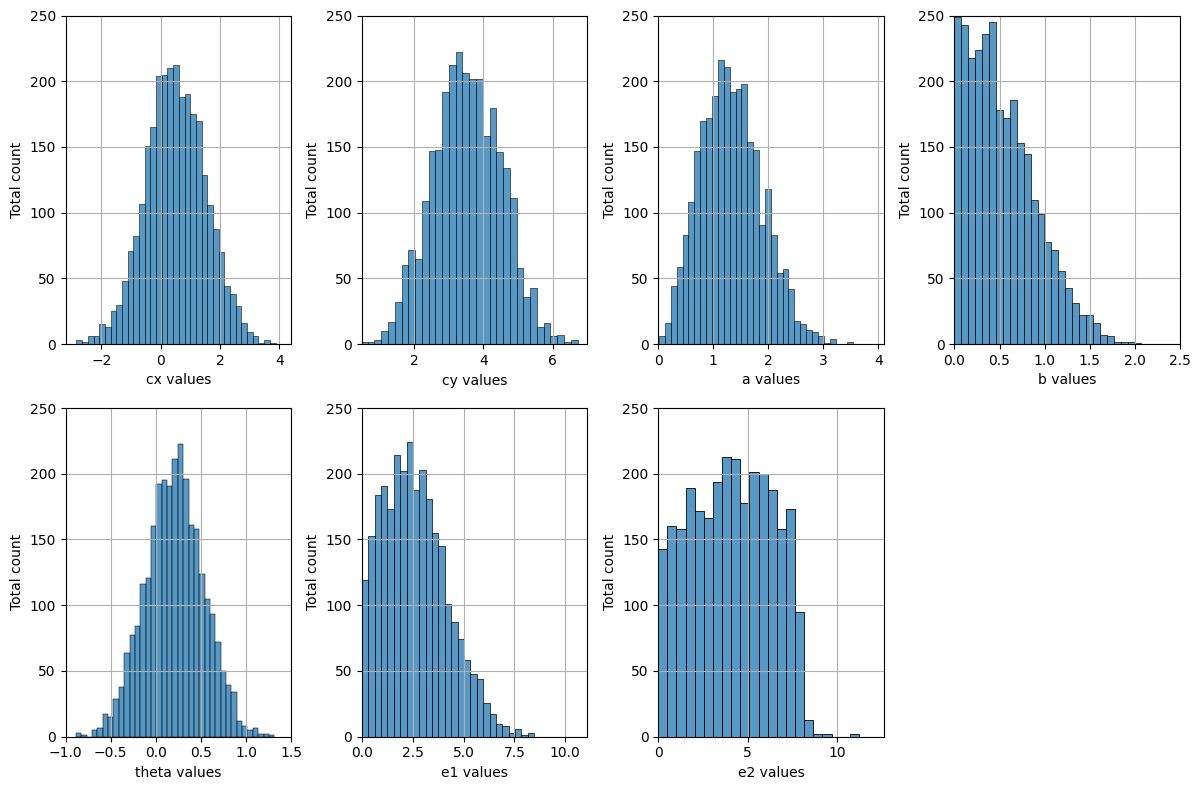

------------- FOLD 2 -------------
        count      mean       std       min       50%        max
cx     2819.0  0.498012  1.007436 -3.102034  0.508030   4.113686
cy     2819.0  3.520248  0.978842  0.733805  3.508731   6.764944
a      2819.0  1.344029  0.572470  0.041099  1.317173   3.642976
b      2819.0  0.543949  0.381603  0.000376  0.475042   2.204865
theta  2819.0  0.199845  0.317564 -0.828643  0.197233   1.435599
e1     2819.0  2.612632  1.589360  0.003180  2.453604   9.153356
e2     2819.0  4.114239  2.269444  0.002443  4.088339  13.713040
fold   2819.0  2.000000  0.000000  2.000000  2.000000   2.000000


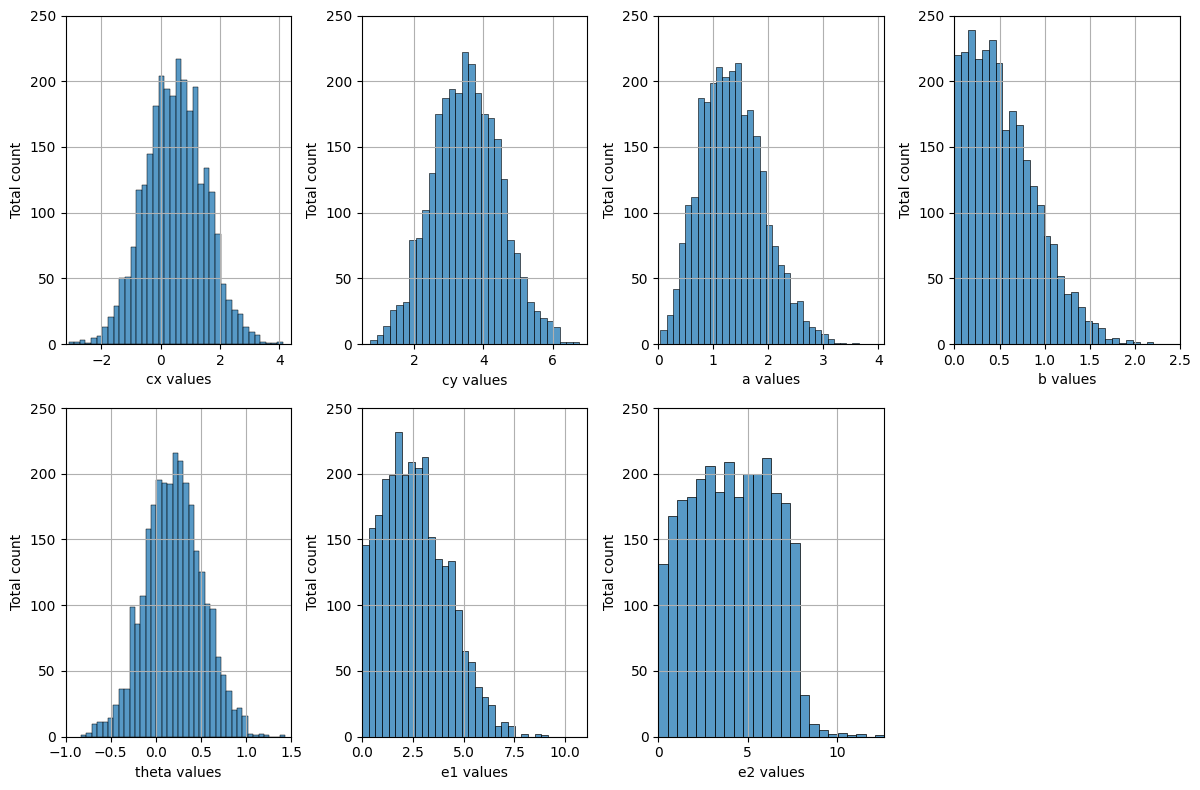

------------- FOLD 3 -------------
        count      mean       std       min       50%        max
cx     2819.0  0.494933  0.975826 -2.606321  0.483264   3.380020
cy     2819.0  3.503880  0.994089  0.634642  3.484797   6.572892
a      2819.0  1.332282  0.542453  0.032033  1.303745   3.702683
b      2819.0  0.550266  0.383904  0.001307  0.492904   2.429068
theta  2819.0  0.203424  0.319687 -0.977577  0.195352   1.248117
e1     2819.0  2.613577  1.574657  0.000064  2.494894   9.010049
e2     2819.0  4.072458  2.212026  0.001964  4.065267  10.745827
fold   2819.0  3.000000  0.000000  3.000000  3.000000   3.000000


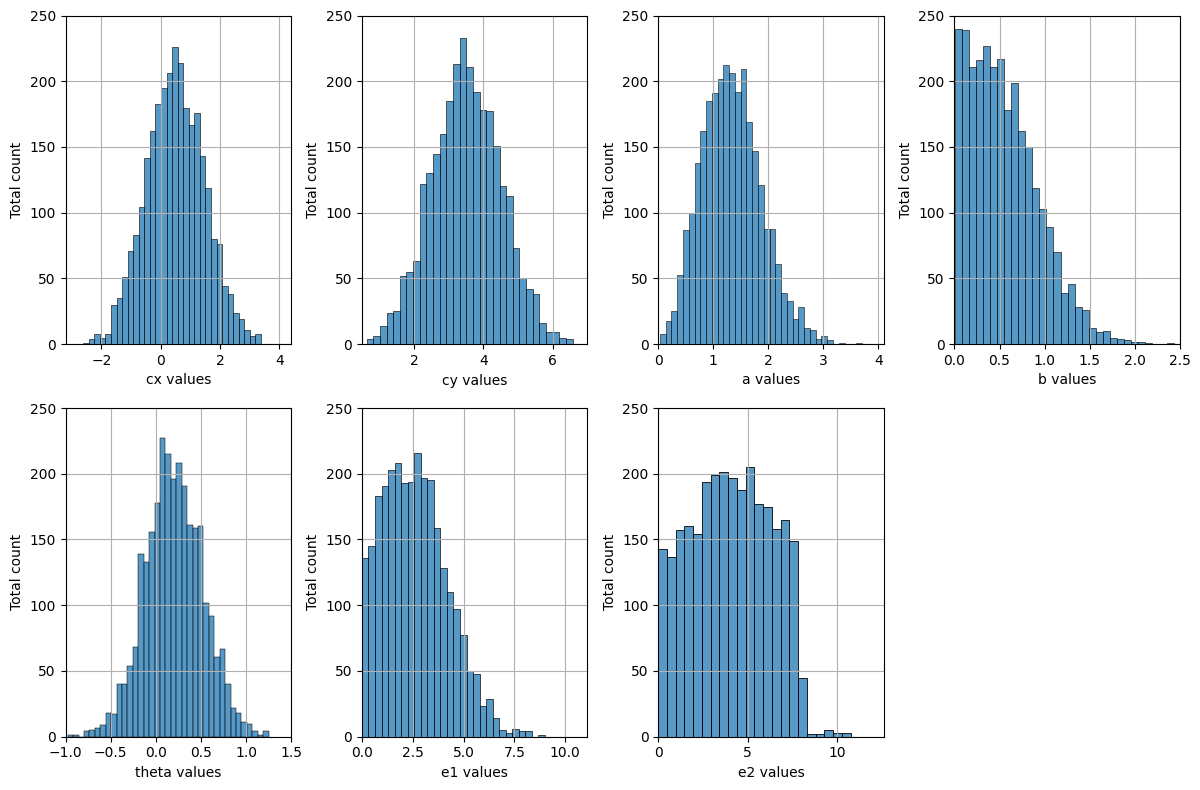

------------- FOLD 4 -------------
        count      mean       std       min       50%        max
cx     2819.0  0.480424  1.013485 -2.827629  0.478073   4.378377
cy     2819.0  3.510529  0.970736  0.771927  3.462020   7.286987
a      2819.0  1.350033  0.556915  0.032472  1.320605   4.032865
b      2819.0  0.556052  0.391651  0.000054  0.483092   2.397364
theta  2819.0  0.191075  0.314659 -1.009230  0.192999   1.373240
e1     2819.0  2.585756  1.607226  0.000099  2.409071  11.031250
e2     2819.0  4.065340  2.263529  0.000887  4.052153  12.431744
fold   2819.0  4.000000  0.000000  4.000000  4.000000   4.000000


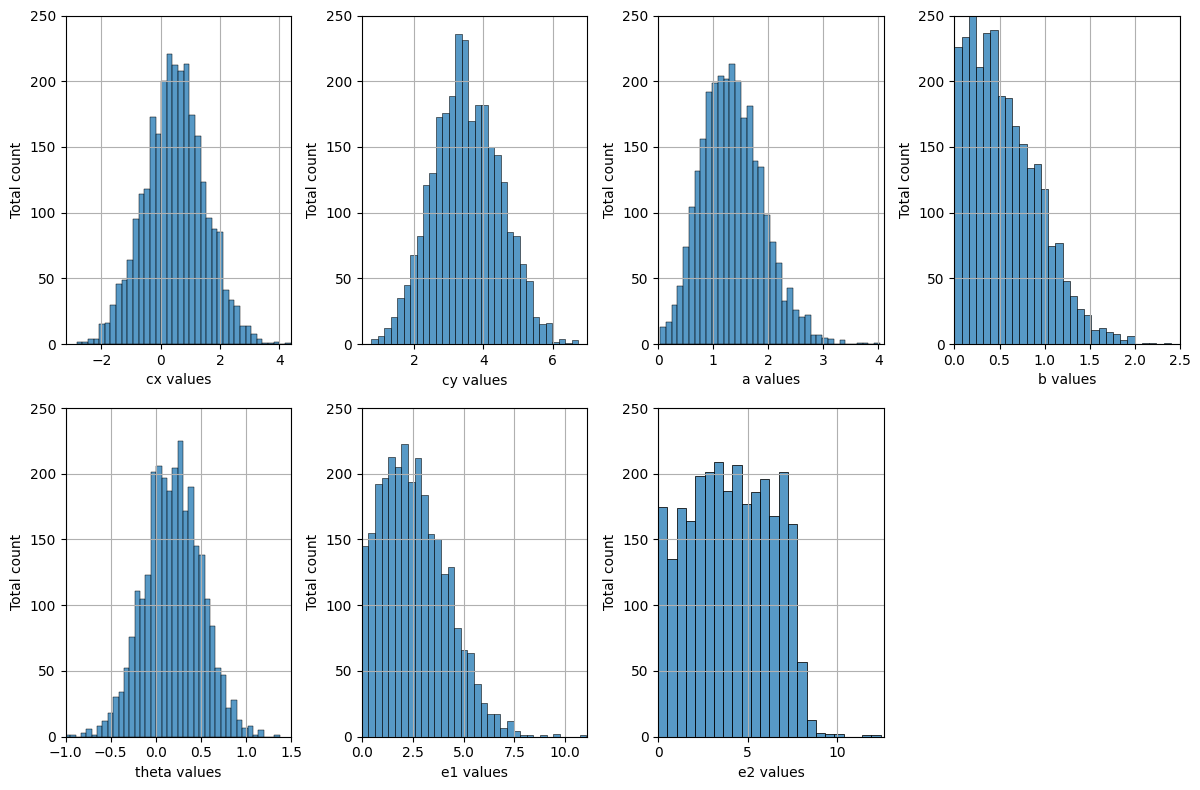

In [36]:
show_distribution = True #Set to true to plot distributions

for i in range(5):
  print(f'------------- FOLD {i} -------------')
  params = y[y['fold'] == i]
  print(params.describe().drop(['25%','75%']).transpose())
  if show_distribution:
    visualize_parameter_distributions(params, 250, file = f"./figures/fold_{i}_distribution.png")

In [37]:
X_train = X[(X['fold'] == 0) | (X['fold'] == 1) | (X['fold'] == 2)]
y_train = y[(y['fold'] == 0) | (y['fold'] == 1) | (y['fold'] == 2)]

X_validation = X[X['fold'] == 3]
y_validation = y[y['fold'] == 3]

X_test = X[X['fold'] == 4]
y_test = y[y['fold'] == 4]

In [38]:
y_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cx,8456.0,0.493348,1.004043,-3.102034,-0.183961,0.486118,1.173025,4.138670
cy,8456.0,3.523111,0.977604,0.276241,2.841487,3.510761,4.214657,6.764944
a,8456.0,1.333981,0.562819,0.015081,0.919543,1.300265,1.700284,3.851698
b,8456.0,0.540653,0.383917,0.000287,0.229895,0.472782,0.782615,2.204865
theta,8456.0,0.201788,0.318825,-0.886144,-0.010453,0.201984,0.416940,1.435599
e1,8456.0,2.616230,1.585771,0.000006,1.370847,2.470020,3.665823,10.031247
e2,8456.0,4.069979,2.248651,0.001369,2.193095,4.056101,5.916066,13.713040
fold,8456.0,1.000000,0.816593,0.000000,0.000000,1.000000,2.000000,2.000000


In [39]:
y_validation.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cx,2819.0,0.494933,0.975826,-2.606321,-0.173159,0.483264,1.167135,3.380020
cy,2819.0,3.503880,0.994089,0.634642,2.815449,3.484797,4.187921,6.572892
a,2819.0,1.332282,0.542453,0.032033,0.931003,1.303745,1.684889,3.702683
b,2819.0,0.550266,0.383904,0.001307,0.240170,0.492904,0.795078,2.429068
theta,2819.0,0.203424,0.319687,-0.977577,-0.009541,0.195352,0.421204,1.248117
e1,2819.0,2.613577,1.574657,0.000064,1.355187,2.494894,3.632271,9.010049
e2,2819.0,4.072458,2.212026,0.001964,2.317593,4.065267,5.873197,10.745827
fold,2819.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [40]:
y_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cx,2819.0,0.480424,1.013485,-2.827629,-0.209991,0.478073,1.144918,4.378377
cy,2819.0,3.510529,0.970736,0.771927,2.824617,3.462020,4.177954,7.286987
a,2819.0,1.350033,0.556915,0.032472,0.941667,1.320605,1.702306,4.032865
b,2819.0,0.556052,0.391651,0.000054,0.236954,0.483092,0.812509,2.397364
theta,2819.0,0.191075,0.314659,-1.009230,-0.017887,0.192999,0.406618,1.373240
e1,2819.0,2.585756,1.607226,0.000099,1.321734,2.409071,3.678455,11.031250
e2,2819.0,4.065340,2.263529,0.000887,2.209815,4.052153,5.970316,12.431744
fold,2819.0,4.000000,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [41]:
save_indexes(X_train['data_index'], './utils/train.txt')
save_indexes(X_validation['data_index'], './utils/validation.txt')
save_indexes(X_test['data_index'], './utils/test.txt')